<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/4.1.1-biGRUB16-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer biDirectional GRU using TensorFlow 2




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = 'drive/My Drive/Springboard/capstone'
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, \
                                    Dropout, Bidirectional, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import importlib
import json
import re
from datetime import datetime

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku
import util.file_util as fu
import util.report_util as ru

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()

RSTATE = 1
import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)



# check to see if we are using GPU - must be placed at the beginning of the program
tf.debugging.set_log_device_placement(True)
print("GPU Available: ", tf.test.is_gpu_available())
print(f'Tensorflow Version: {tf.version.VERSION}')
print(f'Keras Version: {tf.keras.__version__}')


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False

GRU_DIM = 16
MODEL_NAME = f"biGRUB{GRU_DIM}"
ARCHITECTURE = f"1x{GRU_DIM}"
DESCRIPTION = f"1 Layer Bi-directional {GRU_DIM} units, balanced weights"
FEATURE_SET_NAME = "random_embedding"
SAMPLES = "200k"
REPORT_FILE = 'dl_prototype-report.csv'
REPORT_DIR = f'{DRIVE_DIR}/reports'


if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{REPORT_DIR}/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f'test-{REPORT_FILE}')
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{REPORT_DIR}/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)


EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.01
# from our previous notebook, we saw that 90% of our reviews have 100 or less
MAX_SEQUENCE_LENGTH = 100
PATIENCE = 8

start_time = datetime.now()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True
Tensorflow Version: 2.2.0-rc3
Keras Version: 2.3.0-tf


In [0]:

df = pd.read_csv(DATA_FILE)

ratings = df[LABEL_COLUMN]



# Pre-process our data


In [4]:

X_train, X_test, y_train, y_test, tokenizer = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                     report_dir = REPORT_DIR,
                                                      max_sequence_length = MAX_SEQUENCE_LENGTH)

Vocabulary size=57430
Number of Documents=199538
Splitting data into training and test sets...
Training X type <class 'numpy.ndarray'> y type <class 'pandas.core.series.Series'>
Training X shape (149653, 100) y shape (149653,)
Test X shape (49885, 100) y shape (49885,)
Shape of y_train (149653,)
One hot enocde label data...


In [5]:
np.shape(X_train)

(149653, 100)

In [6]:
# Might have to play with this
vocab_size = len(tokenizer.word_counts)


# use functional syntax to create our graph
inp = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
# since we are using OOV - we have to add 2 since there is an extra index plus
# we add 1 according to documentation
x = Embedding(vocab_size + 2, EMBED_SIZE, trainable=True)(inp)
x = Bidirectional(GRU(units=GRU_DIM, return_sequences=False))(x)
# x = Dense(GRU_DIM*2, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(GRU_DIM, activation='relu')(x)
outp = Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate = LEARNING_RATE), 
              metrics=['categorical_accuracy'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          17229300  
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                30528     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 17,259,993
Trainable params: 17,259,993
Non-trainable params: 0
_________________________________________________________________


In [8]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), ratings)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME,
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN,
                     FEATURE_COLUMN,
                     DATA_FILE,
                     embed_size=EMBED_SIZE,
                     tokenizer=tokenizer,
                     description=DESCRIPTION)

history = mw.fit(X_train, 
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=1,
                validation_split=0.2,
                 class_weight = weights_dict,
                callbacks=[early_stop, reduce_lr])

class weights: [1.43769724 3.07691596 2.18277088 1.19627098 0.37238702]
class weights_dict: {0: 1.4376972404351898, 1: 3.076915959907479, 2: 2.182770880052508, 3: 1.1962709832134293, 4: 0.372387022124348}
Number of training examples: 149653
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:

Number of test: 49885
Running model.evaluate...
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_31730

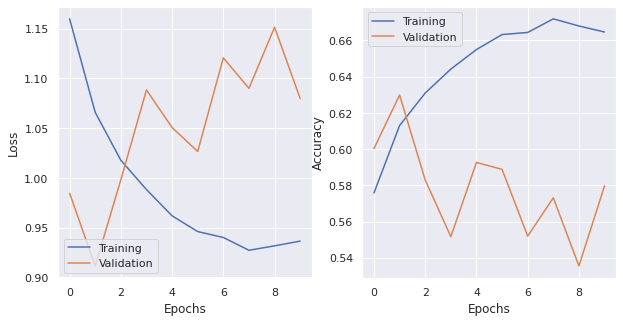


Confusion Matrix
[[ 4053  2025   421   201   258]
 [  810  1358   602   281   182]
 [  366  1176  1432  1071   509]
 [  152   511  1114  3043  3548]
 [  374   547   762  3520 21569]]

Classification Report
              precision    recall  f1-score   support

           1       0.70      0.58      0.64      6958
           2       0.24      0.42      0.31      3233
           3       0.33      0.31      0.32      4554
           4       0.37      0.36      0.37      8368
           5       0.83      0.81      0.82     26772

    accuracy                           0.63     49885
   macro avg       0.50      0.50      0.49     49885
weighted avg       0.65      0.63      0.64     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

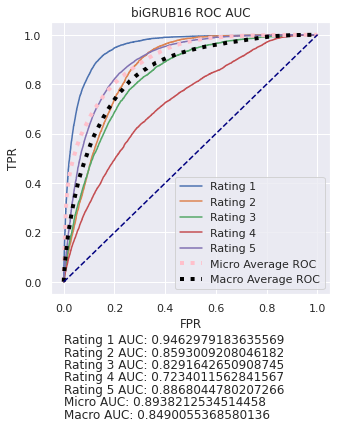

In [9]:
importlib.reload(pu)

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [10]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.4449966731380292


# Save off files so we can load later

In [11]:
mw.save(DRIVE_DIR, append_report=False)


description: biGRUB16-1x16-random_embedding-sampling_none-199538-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
{'model_name': 'biGRUB16', 'architecture': '1x16', 'description': '1 Layer Bi-directional GRU (16 units), balanced weights', 'feature_column': '{"1": {"precision": 0.704257167680278, "recall": 0.5824949698189135, "f1-score": 0.6376150397231181, "support": 6958}, "2": {"precision": 0.24176606729570946, "recall": 0.4200433034333436, "f1-score": 0.3068926553672316, "support": 3233}, "3": {"precision": 0.3306395751558531, "recall": 0.3144488361879666, "f1-score": 0.32234102419808663, "support": 4554}, "4": {"precision": 0.37493839329719075, "recall": 0.3636472275334608, "f1-score": 0.3692065032759039, "support": 8368}, "5": {"precision": 0.8274764060461904, "recall": 0.8056551621096668, "f1-score": 0.816420000757031, "support": 26772}, "accuracy": 0.6305502656109051, "macro avg": {"precision": 0.4958155218950444, "recall

In [15]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in 

In [16]:
  end_time = datetime.now()
  print(f'Report filename: {ku.ModelWrapper.get_report_file_name(DRIVE_DIR, use_date=False)}')
  print(f'Star Time: {start_time }\nEnd time: {end_time}\nTotal Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')


Report filename: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Star Time: 2020-05-02 12:50:02.919084
End time: 2020-05-02 13:17:10.394481
Total Duration: 27.12 mins
